In [4]:
import boto3
import time
import json

session = boto3.Session(profile_name='nikita')
log_client = session.client('logs')


import numpy as np
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
space = [0.5, 1, 1.5, 2]

# Query results

In [6]:
query = log_client.start_query(
    logGroupName='/aws/batch/job',
    startTime=0,
    endTime=int(time.time()),
    queryString="""
        fields @message
        | filter success == 1
        | limit 10000
    """,
    limit=10000
)

In [7]:
query_result = {'status': 'Scheduled'}
while query_result['status'] in ('Scheduled', 'Running'):
    query_result = log_client.get_query_results(queryId=query['queryId'])
    time.sleep(1)

In [36]:
data = [
    json.loads(row[0]['value'])
    for row in query_result['results']
]

In [37]:
len(data)

8006

In [38]:
useful = [x for x in data if x['player'].startswith('UCTPlayer') and x['opponent'].startswith('UCTPlayer') and "version" not in x]

In [39]:
match

{'player': 'UCTPlayer(0, td(seconds=0.1), c=math.sqrt(2) / 2)',
 'opponent': 'UCTPlayer(1, td(seconds=0.1), c=1)',
 'duration': 6.3519,
 'depth': 61,
 'score': [26, 13],
 'winner': 0,
 'success': True}

In [45]:
from datetime import timedelta as td
class UCTPlayer:
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs


from collections import defaultdict
summary = defaultdict(list)

for match in useful:
    reverse = 'math.sqrt(2) / 2)' in match['opponent']
    c = eval(match['player'] if reverse else match['opponent']).kwargs['c']
    w = match['winner']
    if w is None:
        summary[c].append(0.5)
    else:
        summary[c].append((w + reverse) % 2)

In [46]:
ratios = {k: sum(v)/len(v) for k,v in summary.items()}

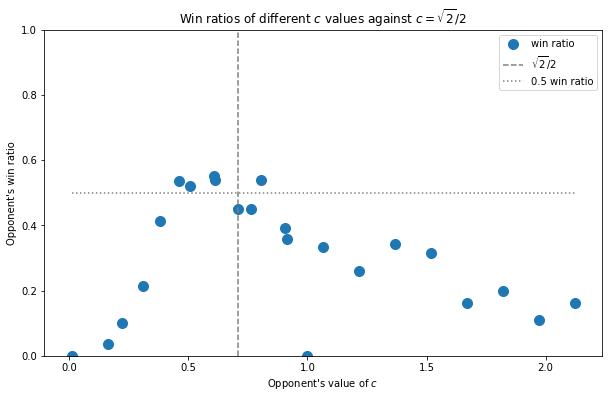

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(
    list(summary.keys()),
    [sum(v)/len(v) for v in summary.values()],
    #c=[len(v) for v in summary.values()],
    label='win ratio',
    s=100
)
SQRT22 = math.sqrt(2)/2
space = list(summary.keys())
plt.vlines(SQRT22, 0, 1, linestyles='dashed', label="$\sqrt{2}/2$", color="grey")
plt.hlines(0.5, min(space) , max(space), linestyles='dotted', label="0.5 win ratio", color="grey")
plt.legend()
#cb = plt.colorbar()
#cb.set_label('# of matches', rotation=270)
#cb.ax.set_yticklabels([int(i) for i in cb.get_ticks()])
#cb.ax.get_yaxis().labelpad = 15

plt.ylim(0, 1)

plt.title("Win ratios of different $c$ values against $c = \sqrt{2}/2$");
plt.xlabel("Opponent's value of $c$")
plt.ylabel("Opponent's win ratio");

plt.savefig("uct-value.png")

In [50]:
max(list(summary.keys()))

2.121320343559643